In [1]:
!nvidia-smi

Thu Oct  7 12:43:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
!rm open-images-bus-trucks.zip
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

In [ ]:
!pip install torch-snippets
from PIL import Image
from torch_snippets import *
import numpy as np
import pandas as pd
import cv2
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torchvision

In [4]:
dataset=pd.read_csv('/content/df.csv')
dataset.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
img_folder = '/content/images/images/'

In [7]:
class OpenDataset(Dataset):
  def __init__(self,data):
    self.data=data
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  def __len__(self):
    return len(self.data)
  def __getitem__(self,ix):
    image = self.data.iloc[ix,0]
    image = image + '.jpg'
    image_path = os.path.join(img_folder, image)
    img = (cv2.imread(image_path)[:,:,::-1])
    img = cv2.resize(img, (300, 300))/255
    box = self.data.iloc[ix,4:8].values
    temp = box[1]
    box[1] = box[2]
    box[2] = temp
    classes = self.data.iloc[ix,2]
    if (classes=='Bus'):
      classes=[1]
    elif (classes=='Truck'):
      classes=[2]
    box=[(box* np.array([300,300,300,300])).astype(np.uint16).tolist()]     
    return img, box, classes
  def collate_fn(self, batch):
    images, boxes, labels = [], [], []
    for item in batch:
      img, image_boxes, image_labels = item
      img = torch.tensor(img).permute(2,0,1)
      img = self.normalize(img)
      img = img.float().to(device)
      images.append(img[None])
      boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
      labels.append(torch.tensor(image_labels).long().to(device))
    images = torch.cat(images).to(device)
    return images, boxes, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


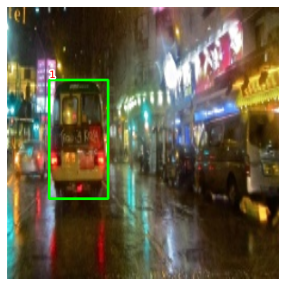

[[46, 80, 111, 211]] [1]


In [8]:
test = OpenDataset(dataset)
img,box,classes= test[3]
show(img, texts=classes, bbs=box, sz=5)
print(box, classes)

In [9]:
from torch.utils.data import DataLoader
train = OpenDataset(dataset)
train_loader = DataLoader(train, batch_size=16, collate_fn=train.collate_fn ,drop_last=True)

In [10]:
def train_batch(inputs, model, criterion, optimizer):
  model.train()
  images, boxes, labels = inputs
  regr, clss = model(images)
  loss = criterion(regr, clss, boxes, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [11]:
from model import SSD300, MultiBoxLoss
from detect import *

In [12]:
model = SSD300(3, device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy,device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [13]:
Loss=[]

In [14]:
for epoch in range(0, 2):
  print(epoch)
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    batch_loss.append(loss.item())
  Loss.append(np.mean(batch_loss))

0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1


In [15]:
for epoch in range(2, 4):
  print(epoch)
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    batch_loss.append(loss.item())
  Loss.append(np.mean(batch_loss))

2
3


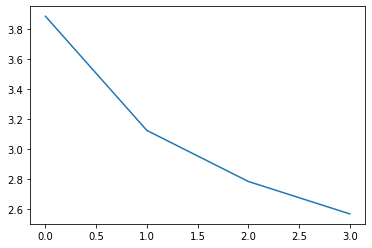

In [16]:
plt.plot(Loss)

[[75, 43, 177, 134]] tensor([1], device='cuda:0') [0.9081692099571228]


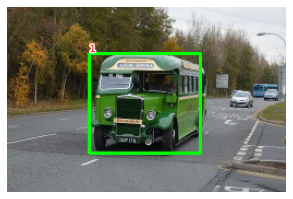

In [17]:
img_path='/content/images/images/004e03d45963728e.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

[[69, 74, 227, 172]] tensor([2], device='cuda:0') [0.9461985230445862]


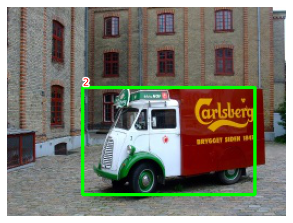

In [18]:
img_path='/content/images/images/003551f1525e49af.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

In [19]:
torch.save(model.to('cpu').state_dict(), '/content/SSD.pth')